# Train a CNN with OpenSoundscape to detect A. varius calls in audio data

This notebook demonstrates how we trained a single-class CNN for the purposes of detecting a rare anuran's vocalizations in field data.
Our CNN uses a ResNet34 CNN architecture with similar preprocessing pipelines and a 1-second clip length.
Here, we only present how to train a single-class CNN to avoid loading too much audio data. To add multiple classes, the user can simply specify additional classes when initializing the model and when creating training data.

## Setup and Imports

In [33]:
import os
import warnings
import pandas as pd
import glob
from datetime import datetime
from sklearn.model_selection import train_test_split

from opensoundscape import CNN
from opensoundscape.ml.cnn import load_model, use_resample_loss
from opensoundscape.ml import cnn_architectures
from opensoundscape.preprocess.preprocessors import SpectrogramPreprocessor
from opensoundscape.data_selection import resample

from opensoundscape import Audio, Spectrogram
import IPython.display as ipd

warnings.filterwarnings("ignore")

In [27]:
OUTPUT_DIR = 'sample_scores/CNN'
TEST_DIR = 'sample_audio'

## Single-class CNN

### Parameters and setup

In [23]:
# Directory with training data
sample_dir = 'sample_templates'
sample_files = glob.glob(os.path.join(sample_dir, '*wav'))

print(f"Found {len(sample_files)} sample files.")

# Define the sample duration (in seconds)
# Since our samples are longer than our clip length, we'll take the middle section
s = 1.0
dur = 1.0

# Create a simple dataframe from the sample file paths.
# We'll set 'start_time' = s and 'end_time' = s+dur for each sample,
# and use the file name (without extension) as a dummy label.
data = []
for f in sample_files:
    base = os.path.splitext(os.path.basename(f))[0]
    data.append({'file': f, 'start_time': s, 'end_time': s+dur, 'avar': 1})

# Create the DataFrame and set a multi-index as expected by the training pipeline.
df = pd.DataFrame(data)
df = df.set_index(['file', 'start_time', 'end_time'])

print("Sample training dataframe:")
print(df)

# Split the data: use 4 samples for training and 2 for validation.
train_df, valid_df = train_test_split(df, train_size=4/6, random_state=42)
print(f"Training samples: {len(train_df)}; Validation samples: {len(valid_df)}")


Found 6 sample files.
Sample training dataframe:
                                                               avar
file                                      start_time end_time      
sample_templates/atelopus_varius_call.wav 1.0        2.0          1
sample_templates/template_3.wav           1.0        2.0          1
sample_templates/template_2.wav           1.0        2.0          1
sample_templates/template_1.wav           1.0        2.0          1
sample_templates/template_5.wav           1.0        2.0          1
sample_templates/template_4.wav           1.0        2.0          1
Training samples: 4; Validation samples: 2


In [24]:
# Define training parameters
epochs = 5
num_workers = 1
model_save = OUTPUT_DIR
batch_size = 4

# Load an overlay DataFrame if desired; here, we pass an empty DataFrame.

try:
    over_df = pd.read_csv('sample_templates/overlay.csv', index_col='file')[[]]
except Exception:
    over_df = pd.DataFrame()

### Train Model

In [25]:
# Initialize the single-class CNN model with ResNet34 architecture
model = CNN(
    cnn_architectures.resnet34(num_classes=1),
    classes=['avar'],
    sample_duration=dur,
    sample_shape=(180, 224, 1)
)
model.preprocessor = SpectrogramPreprocessor(
    sample_duration=dur,
    overlay_df=over_df,
    width=224,
    height=180,
    channels=3
)

# Configure the preprocessing pipeline
model.preprocessor.pipeline.load_audio.set(load_metadata=False)
model.preprocessor.pipeline.random_affine.set(translate=(0.08, 0.0))
model.preprocessor.pipeline.to_spec.set(window_samples=512, overlap_fraction=0.9)
model.preprocessor.pipeline.bandpass.set(min_f=270, max_f=8000)
model.preprocessor.pipeline.frequency_mask.set(max_width=0.05, max_masks=8)
model.preprocessor.pipeline.time_mask.set(max_width=0.04, max_masks=2)
model.preprocessor.pipeline.rescale.set(input_mean=0.55, input_std=0.4)
model.preprocessor.pipeline.add_noise.bypass = False
model.preprocessor.pipeline.overlay.set(overlay_weight=[0.05, 0.3])

model.optimizer_params['lr'] = 0.007

In [26]:
# Train the model using our training set.
model.train(
    train_df,
    valid_df,
    epochs=epochs,
    save_path=model_save,
    batch_size=batch_size,
    num_workers=num_workers,
    raise_errors=False,
    save_interval=3,
)



Training Epoch 0


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0 [batch 0/1, 0.00%] 
	Epoch Running Average Loss: 0.586
	Most Recent Batch Loss: 0.586


/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmpnia0w16k'>
  _warnings.warn(warn_message, ResourceWarning)



Validation.


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmpzids_rmr'>
  _warnings.warn(warn_message, ResourceWarning)



Training Epoch 1


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 [batch 0/1, 0.00%] 
	Epoch Running Average Loss: 0.108
	Most Recent Batch Loss: 0.108


/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmpj27xexsl'>
  _warnings.warn(warn_message, ResourceWarning)



Validation.


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmpnfidd8yy'>
  _warnings.warn(warn_message, ResourceWarning)



Training Epoch 2


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2 [batch 0/1, 0.00%] 
	Epoch Running Average Loss: 0.011
	Most Recent Batch Loss: 0.011


/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmpkp_urfkp'>
  _warnings.warn(warn_message, ResourceWarning)



Validation.


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmper45xf72'>
  _warnings.warn(warn_message, ResourceWarning)



Training Epoch 3


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3 [batch 0/1, 0.00%] 
	Epoch Running Average Loss: 0.002
	Most Recent Batch Loss: 0.002


/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmpxjd4u7dw'>
  _warnings.warn(warn_message, ResourceWarning)



Validation.


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmpyckfs175'>
  _warnings.warn(warn_message, ResourceWarning)



Training Epoch 4


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4 [batch 0/1, 0.00%] 
	Epoch Running Average Loss: 0.000
	Most Recent Batch Loss: 0.000


/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmp9lz71luz'>
  _warnings.warn(warn_message, ResourceWarning)



Validation.


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmp2ubwvpeb'>
  _warnings.warn(warn_message, ResourceWarning)



Best Model Appears at Epoch 0 with Validation score 0.000.


## Run predictions on test data

In [29]:
# Gather test data
test_files = glob.glob(f'{TEST_DIR}/*wav')

In [30]:
# Predict on the test set
predictions = model.predict(
    test_files,
    batch_size=batch_size,
    num_workers=num_workers,
    activation_layer=None
)

  0%|          | 0/45 [00:00<?, ?it/s]

/Users/sash/miniforge3/envs/ops11/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/ct/flqdpp9573b3drcbvfhj15gr0000gn/T/tmpc78tz6q0'>
  _warnings.warn(warn_message, ResourceWarning)


## Review high-scoring clips

In [32]:
# To better "see" the call, we extend the clip by 0.5s in the beginning and at the end.
display_clip_duration = 2

def display_results(result_tuple, play_audio=True):
    """
    - Calculate and plot the spectrogram of the audio clip selected for review.
    - Report relevant information about the clip, including its RIBBIT score.
    - If desired, listen to the audio clip.
    """
    print(f"Displaying audio file: {result_tuple[0]} at {result_tuple[1]} seconds:")
    # Load in desired audio clip (0.5s before true start time)
    audio = Audio.from_file(result_tuple[0], 
                            offset=result_tuple[1]-0.5, 
                            duration=display_clip_duration)
    # Display spectrogram from our audio clip
    Spectrogram.from_audio(
        audio,
        window_samples=256,
        overlap_fraction=.9
    ).bandpass(0,5000).plot()
    # Play audio! :)
    if play_audio:
        ipd.display(ipd.Audio(audio.samples,rate=audio.sample_rate,autoplay=False))
    print(f"This clip got a score of {result_tuple[2]}.\n\n")

Displaying audio file: sample_audio/test_dset_3.wav at 57.0 seconds:


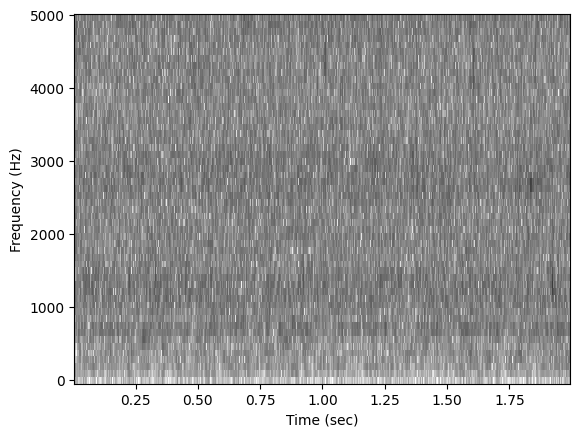

This clip got a score of 7.082344055175781.


Displaying audio file: sample_audio/test_dset_1.wav at 59.0 seconds:


/Users/sash/miniforge3/envs/ops11/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.5 sec instead of 2 sec
  warnings.warn(error_msg)


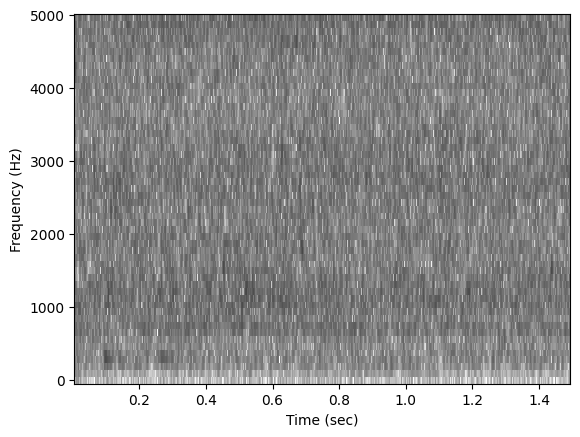

This clip got a score of 6.920506000518799.


Displaying audio file: sample_audio/test_dset_3.wav at 59.0 seconds:


/Users/sash/miniforge3/envs/ops11/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.5 sec instead of 2 sec
  warnings.warn(error_msg)


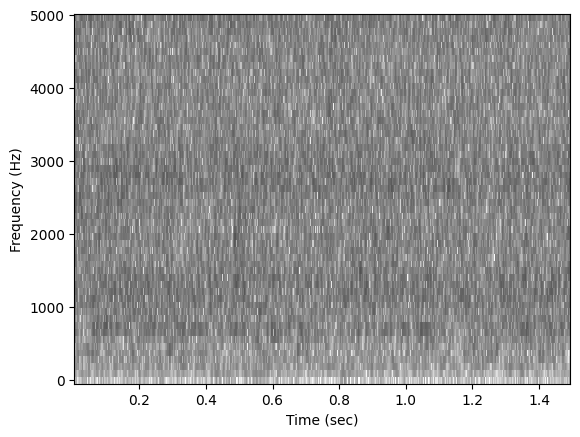

This clip got a score of 6.577314853668213.




In [34]:
"""
Take a closer look at our last score DataFrame to display a desired 
number of highest-scoring clips from the latest file analyzed.
"""
# Set desired number of review clips.
n_review_clips = 3
# Subset DataFrame to that number of high-scoring clips.
clips_to_review = predictions.sort_values(by=['avar'], ascending=False).head(n_review_clips)
# Check out your results!
for index, row in clips_to_review.reset_index().iterrows():
    display_results(tuple(row[["file","start_time","avar"]]), play_audio=True)